# Deep Reinforcement Learning Tutorial - Proximal Policy Optimization
Author: Yu Tang Liu <br>
Email: yutang.liu@tuebingen.mpg.de 

In this tutorial you will practice
- how to write your own PPO algorithm 
- python programming guideline 

reference<br>
[1] openAI SpinningUp https://spinningup.openai.com/en/latest/algorithms/ppo.html<br>
[2] What Matters In On-Policy Reinforcement Learning? A Large-Scale Empirical Study https://arxiv.org/abs/2006.05990

### Black
- python auto-formating tool
- run the first cell to install black and then refresh this notebook
- press the black button at tab to format the code


In [1]:
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
!jupyter nbextension install https://github.com/drillan/jupyter-black/archive/master.zip --user
!jupyter nbextension enable jupyter-black-master/jupyter-black

[I 09:12:48 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 09:12:48 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 09:12:48 InstallContribNbextensionsApp] Installing /home/yliu_local/miniconda3/envs/spinningup/lib/python3.6/site-packages/jupyter_contrib_nbextensions/nbextensions/toc2 -> toc2
[I 09:12:48 InstallContribNbextensionsApp] Up to date: /home/yliu_local/.local/share/jupyter/nbextensions/toc2/toc2.js
[I 09:12:48 InstallContribNbextensionsApp] Up to date: /home/yliu_local/.local/share/jupyter/nbextensions/toc2/demo_dark.png
[I 09:12:48 InstallContribNbextensionsApp] Up to date: /home/yliu_local/.local/share/jupyter/nbextensions/toc2/toc2.yaml
[I 09:12:48 InstallContribNbextensionsApp] Up to date: /home/yliu_local/.local/share/jupyter/nbextensions/toc2/main.css
[I 09:12:48 InstallContribNbextensionsApp] Up to date: /home/yliu_local/.local/share/jupyter/nbextensions/toc2/demo3.gif


Downloading: https://github.com/drillan/jupyter-black/archive/master.zip -> /tmp/tmp96ompsih/master.zip
Extracting: /tmp/tmp96ompsih/master.zip -> /home/yliu_local/.local/share/jupyter/nbextensions
Enabling notebook extension jupyter-black-master/jupyter-black...
      - Validating: OK


### tools 

- torch: map tensor on GPU, build neural network, compute gradient and backpropagation
- gym: a RL test environment set
- spinup: a RL tutorial package

install spinup will also install torch and gym<br>
in the terminal run the following command:
```
sudo apt-get update && sudo apt-get install libopenmpi-dev
git clone https://github.com/openai/spinningup.git
cd spinningup
pip install -e .
```

In [2]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import numpy as np
import gym
from gym.spaces import Discrete, Box

let's import environment and take a look at the specification

In [3]:
env = gym.make("CartPole-v0")
print("action space:", env.action_space)
print("action dimension:", env.action_space.n)
print("observation space:", env.observation_space)
print("observation dimension:", env.observation_space.shape[0])

action space: Discrete(2)
action dimension: 2
observation space: Box(4,)
observation dimension: 4


/home/yliu_local/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


we have 
- discrete action space with dimension 2 
- continuous observation space with dimension 4

here we introduce some useful environment function

In [4]:
obs = env.reset()
print("---call env.reset() to reset environment---")
print("current observation:", obs)

act = env.action_space.sample()
print("---call env.action_space.sample() to sample random action")
print("action:", act)

obs, reward, done, info = env.step(act)
print("---call env.step(act) to perform action to the environment")
print("new observation:", obs)
print("new reward:", reward)

---call env.reset() to reset environment---
current observation: [-0.00226647 -0.03311677  0.01117324 -0.0273437 ]
---call env.action_space.sample() to sample random action
action: 0
---call env.step(act) to perform action to the environment
new observation: [-0.00292881 -0.22839715  0.01062637  0.26884346]
new reward: 1.0


Let's create a policy model with the following components
- linear layer: nn.Linear(in, out)
- activation function: nn.ReLU(), nn.Tanh(), nn.Hardswish()

For example:
```python
input_layer = nn.Linear(4, 10) 
activation_in = nn.ReLU()
hidden_layer0 = nn.Linear(10,10)
activation0 = nn.ReLU()
output_layer = nn.Linear(10, 2)
activation_out = nn.Identity()

layers=[input_layer, activation_in, hidden_layer0, activation0, output_layer, activation_out]
model = nn.Sequential(*layers)
```
Selecting activation function can be treaky. In general, ReLU allow faster convergence but Tanh final performance is usually better. Hardswish is a upgraded ReLU and sometimes can be found in model-based RL context.

In [34]:
def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act()]
    return nn.Sequential(*layers)

In [35]:
obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.n
hidden_sizes = [64, 64]

sizes = [4] + hidden_sizes + [2]
activation = nn.ReLU

model = mlp(sizes, activation=activation)
model

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Identity()
)

It is also easy to foward/infer this model

In [48]:
obs=env.reset()
obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
logits=model.forward(obs_tensor)
print(logits)

tensor([-0.0608,  0.0468], grad_fn=<AddBackward0>)


since the environment has 2 actions, model output also has 2 values, which represents the logits of each action

we can use pytorch categoritcal distribution to turn logits into probability and sample from this policy distribution. This is similar to classifier in machine learning. 

In [75]:
distribution = Categorical(logits=logits)
action=distribution.sample()
print(action)

tensor(1)


It is also convenient to compute log probability of an action when you want to compute the loss function

In [80]:
distribution.log_prob(action)

tensor(-0.6408, grad_fn=<SqueezeBackward1>)

## Let's build our first RL agent
RL agent should have following attributes:
- environment: gym env to play with, e.g. cartpole-v0
- model: policy model, e.g. NN
- optimizer: perform gradient descent, e.g. Adam

and functions:
- train(): defines the training loop
- get_action(): get action from the policy 
- compute_loss(): calculate policy loss  

note: python is a object oriented language, to reuse the code and scale up the code size
- start with class template or abstract
- inherit from this template 

In [67]:
class Abstract_agent:
    def __init__(
        self, env, model, optimizer
    ):
        self.env = env
        self.logits_net = model
        self.optimizer = optimizer

    def get_action(self, obs):
        """
        sample action from the policy distribution
        """
        raise NotImplemented

    def compute_loss(self, obs, act, weights):
        """
        compute policy loss
        """
        raise NotImplemented

    def train(self, n_epochs):
        """
        trainining loop
        """
        raise NotImplemented

In [8]:
#note: you can always black the code cell
class Agent(Abstract_agent):
    def __init__(self,   env, model   , optimizer=    Adam,     batch_size =5000, 
                 render =   False):
        super().__init__(env,    model, optimizer)
                
        self.batch_size  =    batch_size
        self.render          =   render
    
    def get_policy(self, obs):
        """
        return policy distribution by model inference, 
        e.g. logits = model(obs)
        distribution=Categorical(logits)
        """
        ######### Insert Code Here #########
        logits = self.logits_net(obs)
        distribution = Categorical(logits=logits)
        ####################################
        return distribution

    def get_action(self, obs):
        """
        sample action from the policy distribution
        i.e. policy_distribution.sample().item()
        """
        ######### Insert Code Here #########
        action=self.get_policy(obs).sample().item()
        ####################################
        return action

    def compute_loss(self, obs, act, weights):
        """
        policy loss, i.e. averaging over -(logprob * weights)
        note: do not confuse weights with NN's weight and bias, 
            here it represent the reward weight for credit assignment
        """
        ######### Insert Code Here #########
        logp = self.get_policy(obs).log_prob(act)
        loss_pi = -(logp * weights).mean()
        ####################################
        return loss_pi
    
    def policy_update(self,batch_obs,batch_acts,batch_weights):
        """
        update the policy model by performing a gradient descent
        """
        ######### Insert Code Here #########
        # take a single policy gradient update step
        # you need to
        # 1. clean the optimizer gradient by self.optimizer.zero_grad() (required by torch)
        # 2. compute batch_loss by batch_loss=self.compute_loss(obs, act, weights)
        # 3. update the gradient by gradient propagation, batch_loss.backward()
        # 4. run the optimizer by self.optimizer.step()
        
        self.optimizer.zero_grad()
        batch_loss = self.compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
                                  act=torch.as_tensor(batch_acts, dtype=torch.int32),
                                  weights=torch.as_tensor(batch_weights, dtype=torch.float32)
                                  )
        batch_loss.backward()
        self.optimizer.step()
        return batch_loss        

    # for training policy
    def train_one_epoch(self,):
        """
        1. collect (state, action, reward) pair and save in batch
        2. train model with the batch
        """
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False

        # collect experience by acting in the environment with current policy
        while True:

            # rendering
            if (not finished_rendering_this_epoch) and render:
                self.env.render()

            # save obs
            batch_obs.append(obs.copy())

            # act in the environment
            act = self.get_action(torch.as_tensor(obs, dtype=torch.float32))
            obs, rew, done, _ = self.env.step(act)

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a|s) is R(tau)
                batch_weights += [ep_ret] * ep_len

                # reset episode-specific variables
                obs, done, ep_rews = env.reset(), False, []

                # won't render again this epoch
                finished_rendering_this_epoch = True

                # end experience loop if we have enough of it
                if len(batch_obs) > self.batch_size:
                    break

        batch_loss=self.policy_update(batch_obs, batch_acts,batch_weights)
        
        return batch_loss, batch_rets, batch_lens
    
    def train(self, n_epoch):
        for i in range(n_epoch):
            batch_loss, batch_rets, batch_lens = self.train_one_epoch()
            print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                    (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))
        print('training finished')
        self.env.close()

In [9]:
env_name = "CartPole-v0"
hidden_sizes = [32]
lr = 1e-2
epochs = 50
batch_size = 5000
render = True

# define env
env=gym.make(env_name)

# create model
model = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts])

# make optimizer, almost always Adam
optimizer = Adam(model.parameters(), lr=lr) 

# get agent
agent=Agent(env, model, optimizer, batch_size, render)

# start training 
agent.train(epochs)

epoch:   0 	 loss: 16.108 	 return: 19.265 	 ep_len: 19.265
epoch:   1 	 loss: 23.517 	 return: 25.556 	 ep_len: 25.556
epoch:   2 	 loss: 26.540 	 return: 29.192 	 ep_len: 29.192
epoch:   3 	 loss: 29.677 	 return: 33.026 	 ep_len: 33.026
epoch:   4 	 loss: 30.353 	 return: 33.353 	 ep_len: 33.353
epoch:   5 	 loss: 31.296 	 return: 35.458 	 ep_len: 35.458
epoch:   6 	 loss: 33.570 	 return: 36.882 	 ep_len: 36.882
epoch:   7 	 loss: 33.048 	 return: 39.310 	 ep_len: 39.310
epoch:   8 	 loss: 39.996 	 return: 46.046 	 ep_len: 46.046
epoch:   9 	 loss: 36.763 	 return: 46.324 	 ep_len: 46.324
epoch:  10 	 loss: 43.342 	 return: 58.953 	 ep_len: 58.953
epoch:  11 	 loss: 47.798 	 return: 62.062 	 ep_len: 62.062
epoch:  12 	 loss: 48.083 	 return: 61.864 	 ep_len: 61.864
epoch:  13 	 loss: 54.178 	 return: 74.029 	 ep_len: 74.029
epoch:  14 	 loss: 52.344 	 return: 68.726 	 ep_len: 68.726
epoch:  15 	 loss: 51.879 	 return: 71.845 	 ep_len: 71.845
epoch:  16 	 loss: 57.220 	 return: 79.7

## Reward-to-Go 
a simple trick to better estimate the value of the state

change the weighting function from
```python
batch_weights += [ep_ret] * ep_len
```
to
```python 
batch_weights += list(reward_to_go(ep_rews))
```

In [10]:
def reward_to_go(rews):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return rtgs

reward_to_go([1,2,3,4,5])

array([15, 14, 12,  9,  5])

In [11]:
class RTG_Agent(Agent):
    def train_one_epoch(self,):
        """
        1. collect (state, action, reward) pair and save in batch
        2. train model with the batch
        """
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False

        # collect experience by acting in the environment with current policy
        while True:

            # rendering
            if (not finished_rendering_this_epoch) and render:
                self.env.render()

            # save obs
            batch_obs.append(obs.copy())

            # act in the environment
            act = self.get_action(torch.as_tensor(obs, dtype=torch.float32))
            obs, rew, done, _ = self.env.step(act)

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a|s) is R(tau)
                batch_weights += list(reward_to_go(ep_rews)) ###

                # reset episode-specific variables
                obs, done, ep_rews = env.reset(), False, []

                # won't render again this epoch
                finished_rendering_this_epoch = True

                # end experience loop if we have enough of it
                if len(batch_obs) > self.batch_size:
                    break

        batch_loss=self.policy_update(batch_obs, batch_acts,batch_weights)
        
        return batch_loss, batch_rets, batch_lens


In [12]:
n_epoch=50
agent=RTG_Agent(env, model, optimizer, batch_size, render)
agent.train(n_epoch)

epoch:   0 	 loss: 49.481 	 return: 184.036 	 ep_len: 184.036
epoch:   1 	 loss: 46.450 	 return: 167.677 	 ep_len: 167.677
epoch:   2 	 loss: 49.875 	 return: 184.321 	 ep_len: 184.321
epoch:   3 	 loss: 48.317 	 return: 174.793 	 ep_len: 174.793
epoch:   4 	 loss: 48.242 	 return: 182.607 	 ep_len: 182.607
epoch:   5 	 loss: 49.514 	 return: 177.724 	 ep_len: 177.724
epoch:   6 	 loss: 50.673 	 return: 191.074 	 ep_len: 191.074
epoch:   7 	 loss: 50.149 	 return: 187.852 	 ep_len: 187.852
epoch:   8 	 loss: 49.254 	 return: 184.107 	 ep_len: 184.107
epoch:   9 	 loss: 50.325 	 return: 186.852 	 ep_len: 186.852
epoch:  10 	 loss: 51.193 	 return: 196.115 	 ep_len: 196.115
epoch:  11 	 loss: 50.378 	 return: 190.407 	 ep_len: 190.407
epoch:  12 	 loss: 51.483 	 return: 198.462 	 ep_len: 198.462
epoch:  13 	 loss: 50.631 	 return: 191.889 	 ep_len: 191.889
epoch:  14 	 loss: 50.948 	 return: 195.000 	 ep_len: 195.000
epoch:  15 	 loss: 51.415 	 return: 199.500 	 ep_len: 199.500
epoch:  

## Question: 
how does reward-to-go function improve training progress?


## It is convenient to define model and buffer to further reuse the code
general rule of thumb: 
- break down the code to small piece can reuse the code easier
- apply inheritence wisely to create different level of abstract 
- when writing the same code repeatedly, consider making them a class

In [13]:
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical


def combined_shape(length, shape=None):
    """a handy function to append shape to the length of batch"""
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)


def count_vars(module):
    """ count the number of trainable variables in the nn"""
    return sum([np.prod(p.shape) for p in module.parameters()])


def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.

    input:
        vector x,
        [x0,
         x1,
         x2]

    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Actor(nn.Module):
    def _distribution(self, obs):
        raise NotImplementedError

    def _log_prob_from_distribution(self, pi, act):
        raise NotImplementedError

    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a


class MLPCategoricalActor(Actor):
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)


class MLPGaussianActor(Actor):
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return Normal(mu, std)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act).sum(
            axis=-1
        )  # Last axis sum needed for Torch Normal distribution


class MLPCritic(nn.Module):
    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(
            self.v_net(obs), -1
        )  # Critical to ensure v has right shape.


class MLPActorCritic(nn.Module):
    def __init__(
        self, observation_space, action_space, hidden_sizes=(64, 64), activation=nn.Tanh
    ):
        super().__init__()

        obs_dim = observation_space.shape[0]

        # policy builder depends on action space
        if isinstance(action_space, Box):
            self.pi = MLPGaussianActor(
                obs_dim, action_space.shape[0], hidden_sizes, activation
            )
        elif isinstance(action_space, Discrete):
            self.pi = MLPCategoricalActor(
                obs_dim, action_space.n, hidden_sizes, activation
            )

        # build value function
        self.v = MLPCritic(obs_dim, hidden_sizes, activation)

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]

In [14]:
model = MLPActorCritic(env.observation_space, env.action_space)

Note: don't forget to turn observation to tensortype before doing inference<br>
Notice that the outcome can change everytime you run the following code as the policy is stochastic.

In [15]:
obs=env.reset()
obs_tensor=torch.as_tensor(obs, dtype=torch.float32)
model.act(obs_tensor)

array(0)

actor and critic net can be called by the following command

In [16]:
action = model.pi._distribution(obs_tensor).sample()
print("action:", action)

value = model.v(obs_tensor)
print("value:", value)

action: tensor(0)
value: tensor(0.0021, grad_fn=<SqueezeBackward1>)


In [17]:
import time
import spinup.algos.pytorch.vpg.core as core
from spinup.utils.logx import EpochLogger
from spinup.utils.mpi_pytorch import setup_pytorch_for_mpi, sync_params, mpi_avg_grads
from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs

class Buffer:
    """
    A buffer for storing trajectories experienced by a VPG agent interacting
    with the environment, and using Generalized Advantage Estimation (GAE-Lambda)
    for calculating the advantages of state-action pairs.
    """

    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        """
        Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size     # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        """
        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates with GAE-Lambda,
        as well as compute the rewards-to-go for each state, to use as
        the targets for the value function.

        The "last_val" argument should be 0 if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = core.discount_cumsum(deltas, self.gamma * self.lam)
        
        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = core.discount_cumsum(rews, self.gamma)[:-1]
        
        self.path_start_idx = self.ptr

    def get(self):
        """
        Call this at the end of an epoch to get all of the data from
        the buffer, with advantages appropriately normalized (shifted to have
        mean zero and std one). Also, resets some pointers in the buffer.
        """
        assert self.ptr == self.max_size    # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = mpi_statistics_scalar(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        data = dict(obs=self.obs_buf, act=self.act_buf, ret=self.ret_buf,
                    adv=self.adv_buf, logp=self.logp_buf)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}


## Vanilla Policy Gradient
define a buffer class to store and query data easier

training loop of vanilla policy gradient<br>
reward-to-go function is inherit from Rtg agent<br>


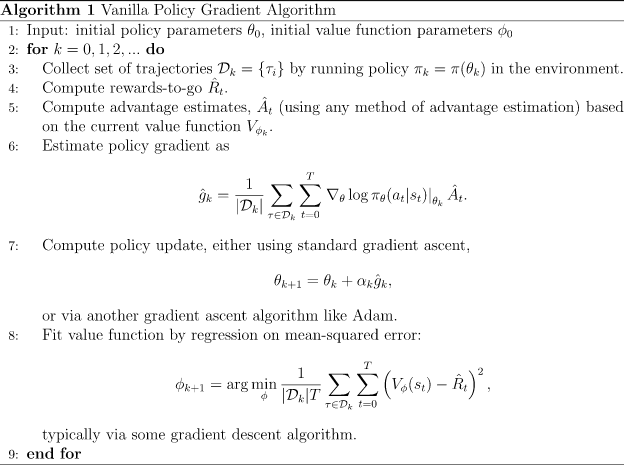

In [18]:
class VPG_Agent(RTG_Agent):
    def __init__(self, env, model=MLPActorCritic, optimizer=Adam, batch_size=5000, render=False, 
                 steps_per_epoch=4000, epochs=50, gamma=0.99, pi_lr=3e-4, vf_lr=1e-3, train_v_iters=80, lam=0.97, 
                 max_ep_len=1000, logger_kwargs=dict(), save_freq=10):
        
        self.epochs=epochs
        self.train_v_iters=train_v_iters
        self.max_ep_len = max_ep_len
        self.save_freq=save_freq
        self.render=render
        
        # Special function to avoid certain slowdowns from PyTorch + MPI combo.
        setup_pytorch_for_mpi()

        self.env = env
        obs_dim = self.env.observation_space.shape
        act_dim = self.env.action_space.shape

        # Sync params across processes
        self.ac = model(env.observation_space, env.action_space)
        sync_params(self.ac)

        # Set up experience buffer
        self.steps_per_epoch=steps_per_epoch
        self.local_steps_per_epoch = int(self.steps_per_epoch / num_procs())
        self.buf = Buffer(obs_dim, act_dim, self.local_steps_per_epoch, gamma, lam)

        # Set up optimizers for policy and value function
        self.pi_optimizer = optimizer(self.ac.pi.parameters(), lr=pi_lr)
        self.vf_optimizer = optimizer(self.ac.v.parameters(), lr=vf_lr)

        # Set up logger to record the experiment
        self.logger = EpochLogger(**logger_kwargs)
        self.logger.save_config(locals())

        # Count variables
        var_counts = tuple(core.count_vars(module) for module in [self.ac.pi, self.ac.v])
        self.logger.log('\nNumber of parameters: \t pi: %d, \t v: %d\n'%var_counts)

    # Set up function for computing VPG policy loss
    def compute_loss_pi(self, data):
        """
        compute policy loss (i.e. -log pi A), 
        """
        obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        ######### Insert Code Here #########
        pi, logp = self.ac.pi(obs, act)
        loss_pi = -(logp * adv).mean()
        ####################################

        # Useful extra info
        approx_kl = (logp_old - logp).mean().item()
        ent = pi.entropy().mean().item()
        pi_info = dict(kl=approx_kl, ent=ent)

        return loss_pi, pi_info

    # Set up function for computing value loss
    def compute_loss_v(self, data):
        """
        compute value loss
        e.g. loss_v is the average of (v - r)^2
        """
        obs, ret = data['obs'], data['ret']
        
        ######### Insert Code Here #########
        loss_v = ((self.ac.v(obs) - ret)**2).mean()
        ####################################
        
        return loss_v
    
    def update_actor(self, data):
        """
        compute policy loss and then perform a gradient descent 
        """
        ######### Insert Code Here #########
        self.pi_optimizer.zero_grad()
        loss_pi, pi_info = self.compute_loss_pi(data)
        loss_pi.backward()
        mpi_avg_grads(self.ac.pi)    # average grads across MPI processes
        self.pi_optimizer.step()
        ####################################
        
        return loss_pi, pi_info
    
    def update_critic(self, data):
        """
        compute critic loss and then perform a gradient descent
        """
        
        ######### Insert Code Here #########
        self.vf_optimizer.zero_grad()
        loss_v = self.compute_loss_v(data)
        loss_v.backward()
        mpi_avg_grads(self.ac.v)    # average grads across MPI processes
        self.vf_optimizer.step()
        ####################################
        
        return loss_v
        

    def update(self):
        """
        compute policy loss and value loss then update actor and critic 
        """
        data = self.buf.get()

        # Get loss and info values before update
        pi_l_old, pi_info_old = self.compute_loss_pi(data)
        pi_l_old = pi_l_old.item()
        v_l_old = self.compute_loss_v(data).item()

#         # Train policy with a single step of gradient descent
        loss_pi, pi_info=self.update_actor(data) 

        # Value function learning
        for i in range(self.train_v_iters):
            loss_v=self.update_critic(data)

        # Log changes from update
        kl, ent = pi_info['kl'], pi_info_old['ent']
        self.logger.store(LossPi=pi_l_old, LossV=v_l_old,
                     KL=kl, Entropy=ent,
                     DeltaLossPi=(loss_pi.item() - pi_l_old),
                     DeltaLossV=(loss_v.item() - v_l_old))

    def train(self):
        # Prepare for interaction with environment
        start_time = time.time()
        o, ep_ret, ep_len = self.env.reset(), 0, 0

        # Main loop: collect experience in env and update/log each epoch
        for epoch in range(self.epochs):
            for t in range(self.local_steps_per_epoch):
                a, v, logp = self.ac.step(torch.as_tensor(o, dtype=torch.float32))

                next_o, r, d, _ = self.env.step(a)
                ep_ret += r
                ep_len += 1

                # save and log
                self.buf.store(o, a, r, v, logp)
                self.logger.store(VVals=v)

                # Update obs (critical!)
                o = next_o

                timeout = ep_len == self.max_ep_len
                terminal = d or timeout
                epoch_ended = t==self.local_steps_per_epoch-1

                if terminal or epoch_ended:
                    if epoch_ended and not(terminal):
                        print('Warning: trajectory cut off by epoch at %d steps.'%ep_len, flush=True)
                    # if trajectory didn't reach terminal state, bootstrap value target
                    if timeout or epoch_ended:
                        _, v, _ = self.ac.step(torch.as_tensor(o, dtype=torch.float32))
                    else:
                        v = 0
                    self.buf.finish_path(v)
                    if terminal:
                        # only save EpRet / EpLen if trajectory finished
                        self.logger.store(EpRet=ep_ret, EpLen=ep_len)
                    o, ep_ret, ep_len = self.env.reset(), 0, 0
                
                if self.render:
                    self.env.render()


            # Save model
            if (epoch % self.save_freq == 0) or (epoch == epochs-1):
                self.logger.save_state({'env': self.env}, None)

            # Perform VPG update!
            self.update()

            # Log info about epoch
            self.logger.log_tabular('Epoch', epoch)
            self.logger.log_tabular('EpRet', with_min_and_max=True)
            self.logger.log_tabular('EpLen', average_only=True)
            self.logger.log_tabular('VVals', with_min_and_max=True)
            self.logger.log_tabular('TotalEnvInteracts', (epoch+1)*self.steps_per_epoch)
            self.logger.log_tabular('LossPi', average_only=True)
            self.logger.log_tabular('LossV', average_only=True)
            self.logger.log_tabular('DeltaLossPi', average_only=True)
            self.logger.log_tabular('DeltaLossV', average_only=True)
            self.logger.log_tabular('Entropy', average_only=True)
            self.logger.log_tabular('KL', average_only=True)
            self.logger.log_tabular('Time', time.time()-start_time)
            self.logger.dump_tabular()
        
        if self.render:
            self.env.close()

In [19]:
agent=VPG_Agent(env=env)
agent.train()

Logging data to /tmp/experiments/1646381919/progress.txt
Saving config:

{
    "act_dim":	[],
    "batch_size":	5000,
    "env":	{
        "<TimeLimit<CartPoleEnv<CartPole-v0>>>":	{
            "_elapsed_steps":	0,
            "_max_episode_steps":	200,
            "action_space":	{
                "Discrete(2)":	{
                    "dtype":	"int64",
                    "n":	2,
                    "np_random":	"RandomState(MT19937)",
                    "shape":	[]
                }
            },
            "env":	{
                "<CartPoleEnv<CartPole-v0>>":	{
                    "_pole_geom":	{
                        "<gym.envs.classic_control.rendering.FilledPolygon object at 0x7f5c493e7208>":	{
                            "_color":	{
                                "<gym.envs.classic_control.rendering.Color object at 0x7f5c493e7358>":	{
                                    "vec4":	[
                                        0.8,
                                        0.6,
    

---------------------------------------
|             Epoch |               0 |
|      AverageEpRet |            19.5 |
|          StdEpRet |            9.11 |
|          MaxEpRet |              63 |
|          MinEpRet |               8 |
|             EpLen |            19.5 |
|      AverageVVals |         -0.0858 |
|          StdVVals |          0.0799 |
|          MaxVVals |           0.124 |
|          MinVVals |          -0.293 |
| TotalEnvInteracts |           4e+03 |
|            LossPi |         0.00878 |
|             LossV |             194 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -117 |
|           Entropy |           0.683 |
|                KL |       -2.83e-10 |
|              Time |            1.44 |
---------------------------------------
---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |            21.9 |
|          StdEpRet |            11.8 |
|          MaxEpRet |              73 |


---------------------------------------
|             Epoch |              10 |
|      AverageEpRet |            23.6 |
|          StdEpRet |            12.4 |
|          MaxEpRet |              73 |
|          MinEpRet |              10 |
|             EpLen |            23.6 |
|      AverageVVals |            13.5 |
|          StdVVals |            5.67 |
|          MaxVVals |            19.7 |
|          MinVVals |          -0.355 |
| TotalEnvInteracts |         4.4e+04 |
|            LossPi |        -0.00813 |
|             LossV |            62.3 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -3.54 |
|           Entropy |           0.688 |
|                KL |       -6.11e-10 |
|              Time |            15.7 |
---------------------------------------
---------------------------------------
|             Epoch |              11 |
|      AverageEpRet |            23.9 |
|          StdEpRet |            13.1 |
|          MaxEpRet |              76 |


---------------------------------------
|             Epoch |              20 |
|      AverageEpRet |            31.1 |
|          StdEpRet |            20.9 |
|          MaxEpRet |             177 |
|          MinEpRet |              10 |
|             EpLen |            31.1 |
|      AverageVVals |            16.7 |
|          StdVVals |            7.15 |
|          MaxVVals |            25.2 |
|          MinVVals |            0.41 |
| TotalEnvInteracts |         8.4e+04 |
|            LossPi |         -0.0288 |
|             LossV |             166 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -13.3 |
|           Entropy |           0.679 |
|                KL |       -2.61e-10 |
|              Time |              30 |
---------------------------------------
---------------------------------------
|             Epoch |              21 |
|      AverageEpRet |              30 |
|          StdEpRet |              17 |
|          MaxEpRet |              96 |


---------------------------------------
|             Epoch |              30 |
|      AverageEpRet |              37 |
|          StdEpRet |            21.4 |
|          MaxEpRet |             112 |
|          MinEpRet |              12 |
|             EpLen |              37 |
|      AverageVVals |              20 |
|          StdVVals |            8.51 |
|          MaxVVals |            30.8 |
|          MinVVals |           0.971 |
| TotalEnvInteracts |        1.24e+05 |
|            LossPi |         -0.0386 |
|             LossV |             152 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -6.8 |
|           Entropy |           0.667 |
|                KL |       -1.83e-09 |
|              Time |            44.2 |
---------------------------------------
---------------------------------------
|             Epoch |              31 |
|      AverageEpRet |            37.1 |
|          StdEpRet |            18.4 |
|          MaxEpRet |             106 |


---------------------------------------
|             Epoch |              40 |
|      AverageEpRet |            42.4 |
|          StdEpRet |            21.2 |
|          MaxEpRet |              97 |
|          MinEpRet |              13 |
|             EpLen |            42.4 |
|      AverageVVals |              23 |
|          StdVVals |            9.14 |
|          MaxVVals |            33.3 |
|          MinVVals |          -0.158 |
| TotalEnvInteracts |        1.64e+05 |
|            LossPi |         -0.0495 |
|             LossV |             114 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -5.76 |
|           Entropy |           0.654 |
|                KL |        -1.2e-09 |
|              Time |            58.5 |
---------------------------------------
---------------------------------------
|             Epoch |              41 |
|      AverageEpRet |            42.7 |
|          StdEpRet |            20.3 |
|          MaxEpRet |             108 |


## Proximal Policy Optimization


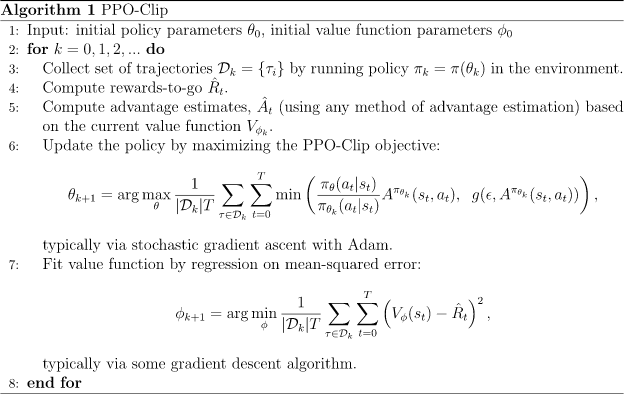

PPO is very similar to VPG,but with few differences <br>

1. PPO use gradient clip to clip the gradient
2. PPO limit the KL different between current and new policy

In order word, PPO limit the allowed difference between current policy and updated policy to ensure the training stability.



In [20]:
import numpy as np
import torch
from torch.optim import Adam
import gym
import time
import spinup.algos.pytorch.ppo.core as core
from spinup.utils.logx import EpochLogger
from spinup.utils.mpi_pytorch import setup_pytorch_for_mpi, sync_params, mpi_avg_grads
from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs


In [21]:
class PPO_Agent(VPG_Agent):
    def __init__(self, env, model=MLPActorCritic, optimizer=Adam, train_pi_iters=80, clip_ratio=0.2, target_kl=0.01,
                 *args, **kwargs):
        super().__init__(env, model, optimizer, *args, **kwargs)
        
        self.train_pi_iters=train_pi_iters
        self.clip_ratio=clip_ratio
        self.target_kl=target_kl
        
        
    # Set up function for computing PPO policy loss
    def compute_loss_pi(self,data):
        """
        compute policy loss (i.e. - log pi A), 
        """
        obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        ######### Insert Code Here #########
        ### compute ratio: exp(logp - logp_old)
        ### compute the clipped_adv: torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
        ### compute loss_pi: -(torch.min(ratio*adv, clipped_adv)).mean()

        pi, logp = self.ac.pi(obs, act)
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1-self.clip_ratio, 1+self.clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
        
        ####################################
        
        # Useful extra info
        approx_kl = (logp_old - logp).mean().item()
        ent = pi.entropy().mean().item()
        clipped = ratio.gt(1+self.clip_ratio) | ratio.lt(1-self.clip_ratio)
        clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()
        pi_info = dict(kl=approx_kl, ent=ent, cf=clipfrac)

        return loss_pi, pi_info

    # Set up function for computing value loss
    def compute_loss_v(self, data):
        """
        compute value loss
        e.g. loss_v is the average of (v - r)^2
        """
        obs, ret = data['obs'], data['ret']
        
        ######### Insert Code Here #########
        loss_v = ((self.ac.v(obs) - ret)**2).mean()
        ####################################
        
        return loss_v
    
    def update_actor(self, data):
        """
        compute policy loss and then perform gradient descent multiple times
        """
        for i in range(self.train_pi_iters): 
        ######### Insert Code Here #########
            self.pi_optimizer.zero_grad()
            loss_pi, pi_info = self.compute_loss_pi(data)

            kl = mpi_avg(pi_info['kl'])
            if kl > 1.5 * self.target_kl:
                self.logger.log('Early stopping at step %d due to reaching max kl.'%i)
                break

            loss_pi.backward()
            mpi_avg_grads(self.ac.pi)    # average grads across MPI processes
            self.pi_optimizer.step()
        ####################################

        self.logger.store(StopIter=i)
        
        return loss_pi, pi_info
    
    def update_critic(self, data):
        """
        compute critic loss and then perform a gradient descent
        """
        self.vf_optimizer.zero_grad()
        loss_v = self.compute_loss_v(data)
        loss_v.backward()
        mpi_avg_grads(self.ac.v)    # average grads across MPI processes
        self.vf_optimizer.step()
        return loss_v

    def update(self):
        """
        compute policy loss and value loss then update actor and critic 
        """
        data = self.buf.get()

        # Get loss and info values before update
        pi_l_old, pi_info_old = self.compute_loss_pi(data)
        pi_l_old = pi_l_old.item()
        v_l_old = self.compute_loss_v(data).item()

        # Train policy with multiple step of gradient descent
        loss_pi, pi_info=self.update_actor(data) 

        
        # Value function learning
        for i in range(self.train_v_iters):
            loss_v=self.update_critic(data)

        # Log changes from update
        kl, ent, cf = pi_info['kl'], pi_info_old['ent'], pi_info['cf']
        self.logger.store(LossPi=pi_l_old, LossV=v_l_old,
                     KL=kl, Entropy=ent, ClipFrac=cf,
                     DeltaLossPi=(loss_pi.item() - pi_l_old),
                     DeltaLossV=(loss_v.item() - v_l_old))


In [22]:
agent=PPO_Agent(env)
agent.train()

Logging data to /tmp/experiments/1646381990/progress.txt
Saving config:

{
    "act_dim":	[],
    "batch_size":	5000,
    "env":	{
        "<TimeLimit<CartPoleEnv<CartPole-v0>>>":	{
            "_elapsed_steps":	0,
            "_max_episode_steps":	200,
            "action_space":	{
                "Discrete(2)":	{
                    "dtype":	"int64",
                    "n":	2,
                    "np_random":	"RandomState(MT19937)",
                    "shape":	[]
                }
            },
            "env":	{
                "<CartPoleEnv<CartPole-v0>>":	{
                    "_pole_geom":	{
                        "<gym.envs.classic_control.rendering.FilledPolygon object at 0x7f5c493e7208>":	{
                            "_color":	{
                                "<gym.envs.classic_control.rendering.Color object at 0x7f5c493e7358>":	{
                                    "vec4":	[
                                        0.8,
                                        0.6,
    

---------------------------------------
|             Epoch |               0 |
|      AverageEpRet |              21 |
|          StdEpRet |             9.8 |
|          MaxEpRet |              61 |
|          MinEpRet |               9 |
|             EpLen |              21 |
|      AverageVVals |          0.0494 |
|          StdVVals |          0.0311 |
|          MaxVVals |           0.121 |
|          MinVVals |         -0.0333 |
| TotalEnvInteracts |           4e+03 |
|            LossPi |        1.29e-08 |
|             LossV |             214 |
|       DeltaLossPi |         -0.0182 |
|        DeltaLossV |            -130 |
|           Entropy |           0.691 |
|                KL |         0.00842 |
|              Time |            1.71 |
---------------------------------------
Early stopping at step 17 due to reaching max kl.
---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |            28.3 |
|          StdEpRet |         

---------------------------------------
|             Epoch |              10 |
|      AverageEpRet |             174 |
|          StdEpRet |            46.5 |
|          MaxEpRet |             200 |
|          MinEpRet |              39 |
|             EpLen |             174 |
|      AverageVVals |            49.8 |
|          StdVVals |            11.4 |
|          MaxVVals |            58.9 |
|          MinVVals |            5.76 |
| TotalEnvInteracts |         4.4e+04 |
|            LossPi |       -2.86e-09 |
|             LossV |             422 |
|       DeltaLossPi |        -0.00386 |
|        DeltaLossV |           -56.7 |
|           Entropy |           0.597 |
|                KL |         0.00287 |
|              Time |            18.2 |
---------------------------------------
---------------------------------------
|             Epoch |              11 |
|      AverageEpRet |             194 |
|          StdEpRet |            17.1 |
|          MaxEpRet |             200 |


---------------------------------------
|             Epoch |              20 |
|      AverageEpRet |             199 |
|          StdEpRet |            5.23 |
|          MaxEpRet |             200 |
|          MinEpRet |             176 |
|             EpLen |             199 |
|      AverageVVals |            64.2 |
|          StdVVals |            7.73 |
|          MaxVVals |            72.1 |
|          MinVVals |            40.8 |
| TotalEnvInteracts |         8.4e+04 |
|            LossPi |        1.91e-09 |
|             LossV |             518 |
|       DeltaLossPi |        -0.00221 |
|        DeltaLossV |            -104 |
|           Entropy |           0.557 |
|                KL |        0.000911 |
|              Time |            35.7 |
---------------------------------------
---------------------------------------
|             Epoch |              21 |
|      AverageEpRet |             200 |
|          StdEpRet |               0 |
|          MaxEpRet |             200 |


---------------------------------------
|             Epoch |              31 |
|      AverageEpRet |             200 |
|          StdEpRet |               0 |
|          MaxEpRet |             200 |
|          MinEpRet |             200 |
|             EpLen |             200 |
|      AverageVVals |            59.4 |
|          StdVVals |            6.87 |
|          MaxVVals |            70.5 |
|          MinVVals |            42.3 |
| TotalEnvInteracts |        1.28e+05 |
|            LossPi |       -1.34e-08 |
|             LossV |             583 |
|       DeltaLossPi |        -0.00468 |
|        DeltaLossV |           -67.1 |
|           Entropy |           0.517 |
|                KL |         0.00482 |
|              Time |            54.7 |
---------------------------------------
---------------------------------------
|             Epoch |              32 |
|      AverageEpRet |             200 |
|          StdEpRet |               0 |
|          MaxEpRet |             200 |


---------------------------------------
|             Epoch |              42 |
|      AverageEpRet |             200 |
|          StdEpRet |               0 |
|          MaxEpRet |             200 |
|          MinEpRet |             200 |
|             EpLen |             200 |
|      AverageVVals |            50.9 |
|          StdVVals |            16.4 |
|          MaxVVals |            67.9 |
|          MinVVals |            9.15 |
| TotalEnvInteracts |        1.72e+05 |
|            LossPi |        3.81e-09 |
|             LossV |             526 |
|       DeltaLossPi |       -0.000605 |
|        DeltaLossV |            -113 |
|           Entropy |           0.525 |
|                KL |         0.00574 |
|              Time |            73.4 |
---------------------------------------
---------------------------------------
|             Epoch |              43 |
|      AverageEpRet |             200 |
|          StdEpRet |               0 |
|          MaxEpRet |             200 |
